In [7]:
import os
import shutil
import random
import torch
import warnings

import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.exceptions import UndefinedMetricWarning

from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [8]:
def split_dataset(source_dir, output_dir, max_per_class=500,train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    random.seed(seed)
    
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Zbirovi moraju dati 1.0"
    
    class_names = os.listdir(source_dir)
    
    for class_name in class_names:
        class_dir = os.path.join(source_dir, class_name)
        images = os.listdir(class_dir)

        images = [img for img in images if img.lower().endswith((".jpg", ".png", ".jpeg"))]

        if len(images) > max_per_class:
            images = random.sample(images, max_per_class)
        else:
            print(f"Klasa {class_name} ima samo {len(images)} slika (traženo {max_per_class}).")

        train_imgs, temp_imgs = train_test_split(images, train_size=train_size, random_state=seed)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size / (test_size + val_size), random_state=seed)

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            
            for img_name in split_imgs:
                src_path = os.path.join(class_dir, img_name)
                dst_path = os.path.join(split_class_dir, img_name)
                shutil.copy(src_path, dst_path)

In [9]:
def evaluate_model(model, dataloader, device):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    metrics = {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds, average='macro', zero_division=0),
        'Recall': recall_score(all_labels, all_preds, average='macro', zero_division=0),
        'F1': f1_score(all_labels, all_preds, average='macro', zero_division=0),
        'AUC-ROC macro': roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro'),
        'AUC-ROC micro': roc_auc_score(all_labels, all_probs, multi_class='ovr', average='micro')
    }

    return metrics

In [10]:
def train_model(train_dir, train_transform, val_loader, test_loader, batch_size=32, num_classes=10, num_epochs=10, lr=0.0001, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train

        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    metrics = evaluate_model(model, test_loader, device)

    return {
        'Model': model,
        **metrics
    }, history

In [11]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.net(x)                 # [B, 1, H, W]
        out = out.view(out.size(0), -1)   # [B, H*W]
        return out.mean(dim=1)

In [14]:
class SingleFolderImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

        if len(self.images) == 0:
            raise RuntimeError(f"Nema slika u folderu: {folder}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [15]:
def train_gan_for_class(class_dir, epochs=20, batch_size=64, transform_Augm=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if transform_Augm:
        transform = transform_Augm
    else:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    dataset = SingleFolderImageDataset(class_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = Generator().to(device)
    D = Discriminator().to(device)

    opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCELoss()
    z_dim = 100

    for epoch in range(epochs):
        for real in loader:
            real = real.to(device)
            batch_size = real.size(0)
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = G(noise)

            loss_D = (
                criterion(D(real), real_labels) +
                criterion(D(fake.detach()), fake_labels)
            )

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            loss_G = criterion(D(fake), real_labels)

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        print(
            f"[GAN][{os.path.basename(class_dir)}] "
            f"Epoch {epoch+1}/{epochs} | "
            f"D: {loss_D.item():.3f} | G: {loss_G.item():.3f}"
        )

    return G

In [16]:
def generate_images(G, out_dir, n_images=300):
    os.makedirs(out_dir, exist_ok=True)
    device = next(G.parameters()).device

    for i in range(n_images):
        z = torch.randn(1, 100, 1, 1).to(device)
        fake = G(z)
        save_image(fake, f"{out_dir}/gan_{i}.png", normalize=False)

In [17]:
def copy_folder(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        raise FileNotFoundError(f"Izvorni folder '{src_dir}' ne postoji.")

    os.makedirs(dst_dir, exist_ok=True)

    for item in os.listdir(src_dir):
        src_path = os.path.join(src_dir, item)
        dst_path = os.path.join(dst_dir, item)

        if os.path.isdir(src_path):
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        else:
            shutil.copy2(src_path, dst_path)

    print(f"Sadržaj foldera '{src_dir}' je kopiran u '{dst_dir}'.")

In [18]:
split_dataset("TrainingSamples", "split_dataset")

# Definicije augmentacija

In [20]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_dict = dict()

transform_dict['ORIGINAL'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Crop'] = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Rotate'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Translate'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05)
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Noise'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize(mean, std),
])

transform_dict['Blur'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['RandomErase'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(
        p=0.5,
        scale=(0.02, 0.2),
        ratio=(0.3, 3.3),
        value='random'
    ),
])

transform_dict['ElasticDistorsion'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ElasticTransform(alpha=50.0, sigma=5.0),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['ColorSpace'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ColorJitter(
        brightness=0.3,   
        contrast=0.3,     
        saturation=0.3,  
        hue=0.05         
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


transform_dict['COMBINED'] = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomApply([
        transforms.RandomRotation(3),
    ], p=0.3),
    transforms.RandomApply([
        transforms.ElasticTransform(alpha=40.0, sigma=5.0),
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.15,
            contrast=0.15,
            saturation=0.15,
            hue=0.03
        ),
    ], p=0.3),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1)),
])

transform_dict['GAN'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['AugmentedGAN'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## Generisanje slika

### GAN

In [23]:
copy_folder("split_dataset/train", "split_dataset/train-gan")

train_root = "split_dataset/train-gan"

transform_GAN = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

for class_name in os.listdir(train_root):
    class_dir = os.path.join(train_root, class_name)

    if not os.path.isdir(class_dir):
        continue

    print(f"Treniram GAN za klasu: {class_name}")

    G = train_gan_for_class(class_dir, transform_Augm=transform_GAN)
    
    n_images = len(os.listdir(class_dir)) // 2
    generate_images(G, class_dir, n_images)

Sadržaj foldera 'split_dataset/train' je kopiran u 'split_dataset/train-gan'.
Treniram GAN za klasu: 0
[GAN][0] Epoch 1/20 | D: 0.166 | G: 4.173
[GAN][0] Epoch 2/20 | D: 0.061 | G: 4.875
[GAN][0] Epoch 3/20 | D: 0.038 | G: 5.412
[GAN][0] Epoch 4/20 | D: 0.023 | G: 5.736
[GAN][0] Epoch 5/20 | D: 0.016 | G: 6.026
[GAN][0] Epoch 6/20 | D: 0.014 | G: 6.076
[GAN][0] Epoch 7/20 | D: 0.010 | G: 6.369
[GAN][0] Epoch 8/20 | D: 0.009 | G: 6.347
[GAN][0] Epoch 9/20 | D: 0.007 | G: 6.655
[GAN][0] Epoch 10/20 | D: 0.007 | G: 6.677
[GAN][0] Epoch 11/20 | D: 0.005 | G: 6.852
[GAN][0] Epoch 12/20 | D: 0.005 | G: 6.913
[GAN][0] Epoch 13/20 | D: 0.004 | G: 7.055
[GAN][0] Epoch 14/20 | D: 0.004 | G: 7.123
[GAN][0] Epoch 15/20 | D: 0.004 | G: 7.110
[GAN][0] Epoch 16/20 | D: 0.004 | G: 7.077
[GAN][0] Epoch 17/20 | D: 0.003 | G: 7.224
[GAN][0] Epoch 18/20 | D: 0.003 | G: 7.218
[GAN][0] Epoch 19/20 | D: 0.003 | G: 7.246
[GAN][0] Epoch 20/20 | D: 0.003 | G: 7.397
Treniram GAN za klasu: 1
[GAN][1] Epoch 1/20 |

### GAN + augmentacija

In [25]:
copy_folder("split_dataset/train", "split_dataset/train-aug-gan")

train_root = "split_dataset/train-aug-gan"

transform_AugmentedGAN = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

for class_name in os.listdir(train_root):
    class_dir = os.path.join(train_root, class_name)

    if not os.path.isdir(class_dir):
        continue

    print(f"Treniram AugmentedGAN za klasu: {class_name}")

    G = train_gan_for_class(
        class_dir,
        transform_Augm=transform_AugmentedGAN
    )

    n_images = len(os.listdir(class_dir)) // 2
    generate_images(G, class_dir, n_images)

Sadržaj foldera 'split_dataset/train' je kopiran u 'split_dataset/train-aug-gan'.
Treniram AugmentedGAN za klasu: 0
[GAN][0] Epoch 1/20 | D: 0.195 | G: 3.845
[GAN][0] Epoch 2/20 | D: 0.078 | G: 4.677
[GAN][0] Epoch 3/20 | D: 0.036 | G: 5.350
[GAN][0] Epoch 4/20 | D: 0.024 | G: 5.755
[GAN][0] Epoch 5/20 | D: 0.019 | G: 5.817
[GAN][0] Epoch 6/20 | D: 0.015 | G: 5.937
[GAN][0] Epoch 7/20 | D: 0.012 | G: 6.176
[GAN][0] Epoch 8/20 | D: 0.009 | G: 6.389
[GAN][0] Epoch 9/20 | D: 0.009 | G: 6.420
[GAN][0] Epoch 10/20 | D: 0.008 | G: 6.534
[GAN][0] Epoch 11/20 | D: 0.006 | G: 6.755
[GAN][0] Epoch 12/20 | D: 0.006 | G: 6.911
[GAN][0] Epoch 13/20 | D: 0.005 | G: 6.903
[GAN][0] Epoch 14/20 | D: 0.004 | G: 7.035
[GAN][0] Epoch 15/20 | D: 0.004 | G: 7.014
[GAN][0] Epoch 16/20 | D: 0.004 | G: 7.121
[GAN][0] Epoch 17/20 | D: 0.003 | G: 7.250
[GAN][0] Epoch 18/20 | D: 0.003 | G: 7.187
[GAN][0] Epoch 19/20 | D: 0.003 | G: 7.121
[GAN][0] Epoch 20/20 | D: 0.003 | G: 7.144
Treniram AugmentedGAN za klasu: 1

In [26]:
results_dict = dict()
results_history = dict()

train_dir = "split_dataset/train"

val_dataset = datasets.ImageFolder("split_dataset/val", transform=transform_dict['ORIGINAL'])
test_dataset = datasets.ImageFolder("split_dataset/test", transform=transform_dict['ORIGINAL'])
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

batch_size = 32
num_classes = 10
num_epochs = 5
lr = 0.001

# Training Loop

In [28]:
for key, train_transform in transform_dict.items():
    print(f"Training with transform: {key}")

    if key == 'GAN':
        results_dict[key], results_history[key] = train_model("split_dataset/train-gan", train_transform, val_loader, test_loader)
    elif key == 'AugmentedGAN':
        results_dict[key], results_history[key] = train_model("split_dataset/train-aug-gan", train_transform, val_loader, test_loader)
    else:
        results_dict[key], results_history[key] = train_model(train_dir, train_transform, val_loader, test_loader, batch_size, num_classes, num_epochs, lr)

Training with transform: ORIGINAL
Epoch 1/5 | Train Loss: 0.2119, Train Acc: 0.9311 | Val Loss: 0.0989, Val Acc: 0.9693
Epoch 2/5 | Train Loss: 0.0743, Train Acc: 0.9771 | Val Loss: 0.1549, Val Acc: 0.9507
Epoch 3/5 | Train Loss: 0.0959, Train Acc: 0.9700 | Val Loss: 0.2413, Val Acc: 0.9240
Epoch 4/5 | Train Loss: 0.0581, Train Acc: 0.9823 | Val Loss: 0.0959, Val Acc: 0.9667
Epoch 5/5 | Train Loss: 0.0255, Train Acc: 0.9920 | Val Loss: 0.0511, Val Acc: 0.9840
Training with transform: Crop
Epoch 1/5 | Train Loss: 0.2470, Train Acc: 0.9254 | Val Loss: 0.1597, Val Acc: 0.9640
Epoch 2/5 | Train Loss: 0.1005, Train Acc: 0.9706 | Val Loss: 0.0707, Val Acc: 0.9787
Epoch 3/5 | Train Loss: 0.0760, Train Acc: 0.9757 | Val Loss: 0.1637, Val Acc: 0.9560
Epoch 4/5 | Train Loss: 0.0791, Train Acc: 0.9737 | Val Loss: 0.0533, Val Acc: 0.9827
Epoch 5/5 | Train Loss: 0.0556, Train Acc: 0.9829 | Val Loss: 0.1080, Val Acc: 0.9667
Training with transform: Rotate
Epoch 1/5 | Train Loss: 0.2345, Train Acc: 0

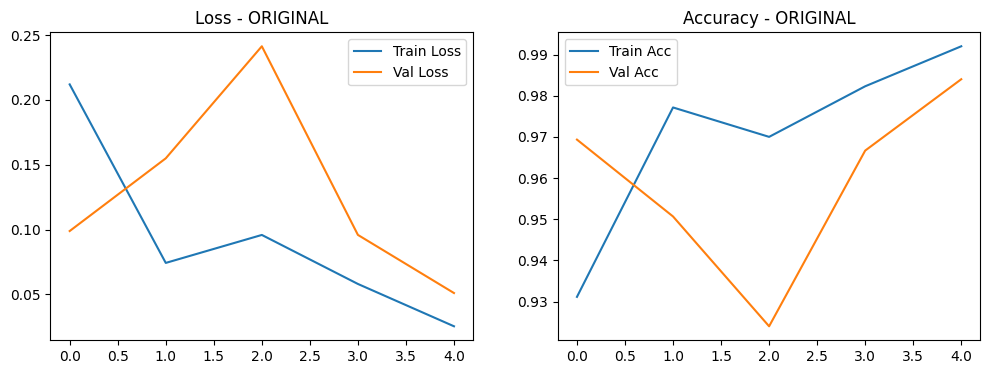

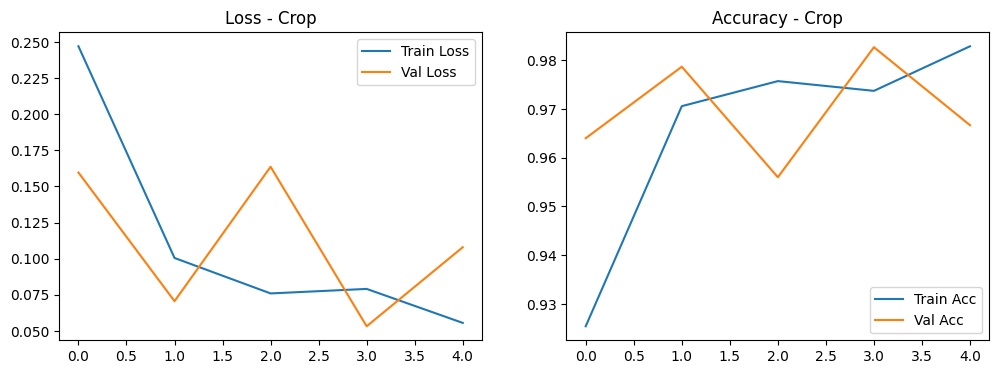

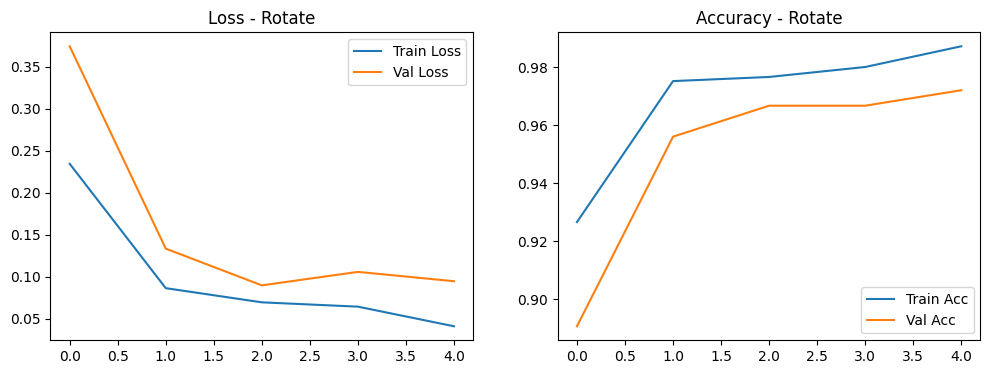

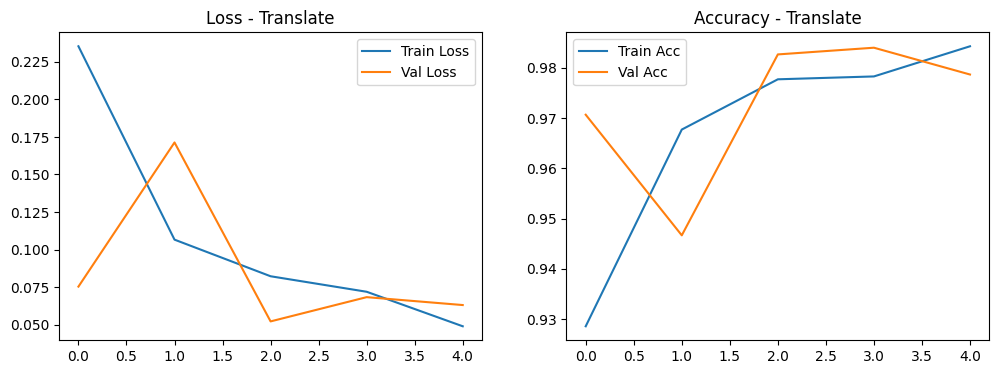

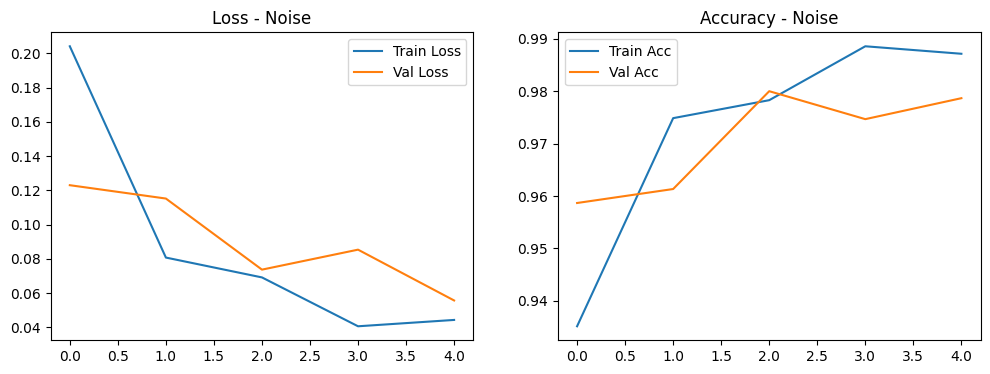

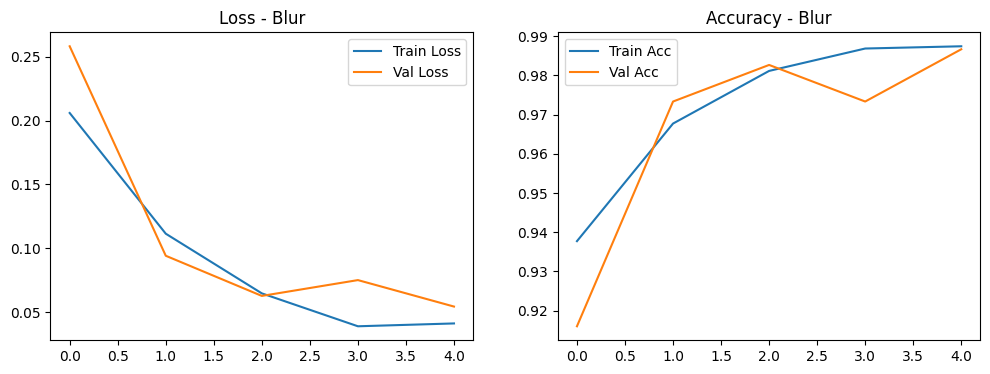

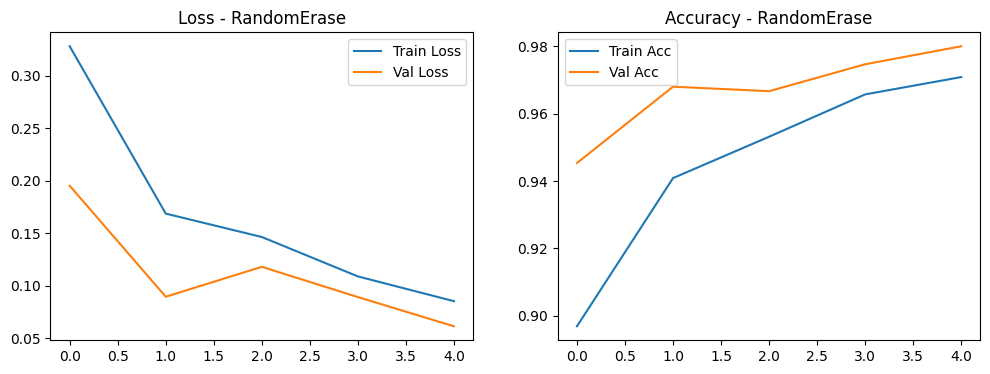

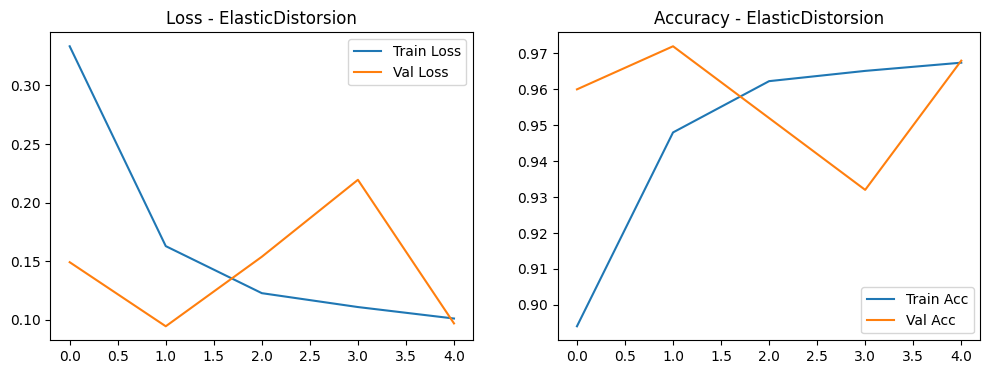

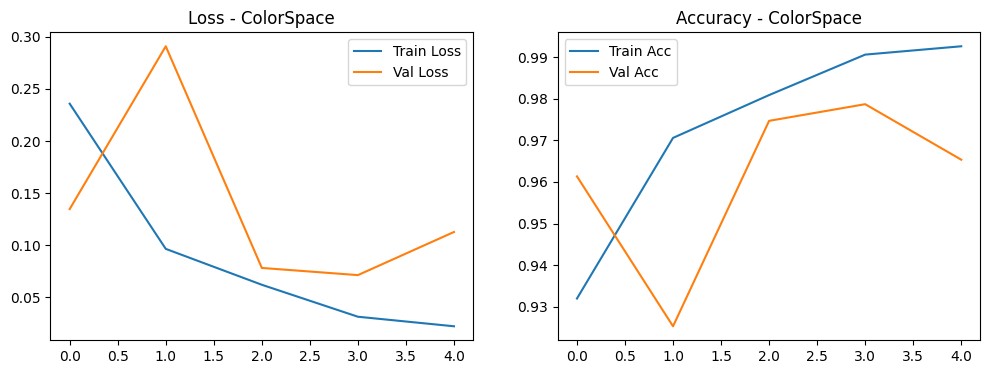

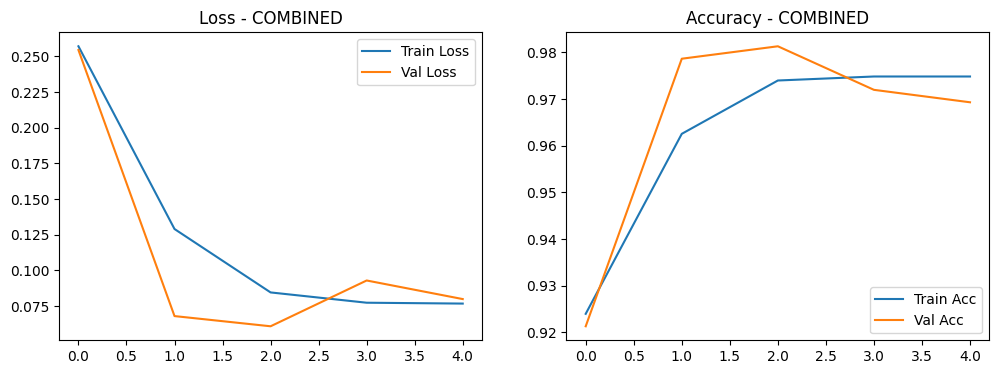

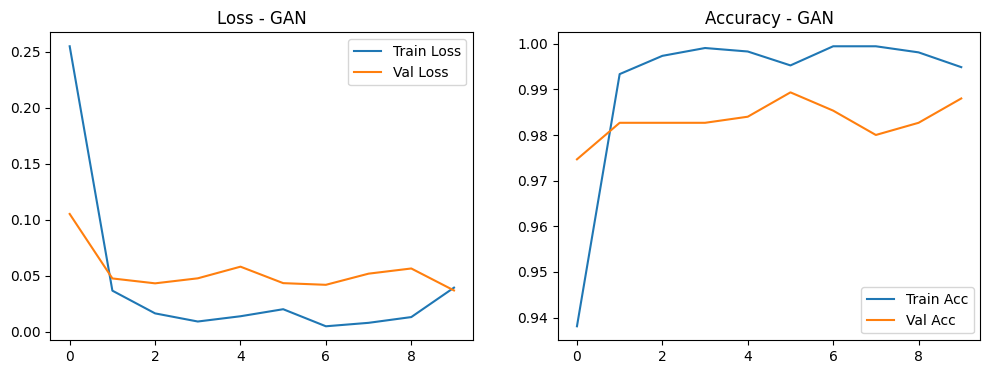

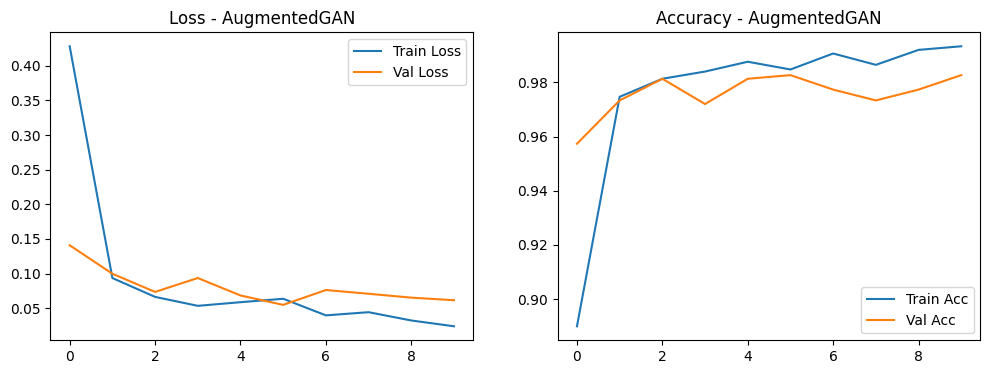

In [29]:
for name, history in results_history.items():
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"Loss - {name}")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(f"Accuracy - {name}")
    plt.legend()
    
    plt.show()

In [30]:
df = pd.DataFrame(results_dict).T
df = df.drop(columns=["Model"])
df = df.apply(pd.to_numeric)

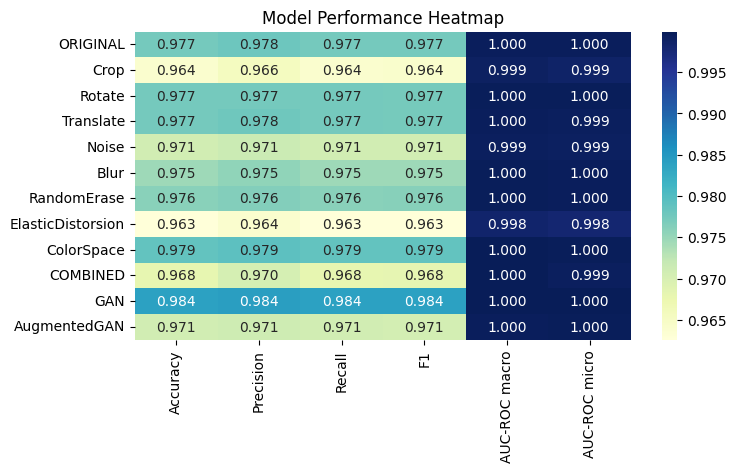

In [42]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df,
    annot=True,           
    cmap="YlGnBu", 
    fmt='.3f'
)

plt.title("Model Performance Heatmap")
plt.show()

## External Test Set [ https://www.kaggle.com/datasets/ayavariabdi/didadataset?select=10000 ]

In [44]:
src_dir = "10000/10000"
dst_dir = "check_validation"

os.makedirs(dst_dir, exist_ok=True)

for class_name in os.listdir(src_dir):
    class_src_path = os.path.join(src_dir, class_name)
    class_dst_path = os.path.join(dst_dir, class_name)
    
    os.makedirs(class_dst_path, exist_ok=True)
    
    all_images = [f for f in os.listdir(class_src_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sample_images = random.sample(all_images, min(500, len(all_images)))
    
    for img_name in sample_images:
        src_path = os.path.join(class_src_path, img_name)
        dst_path = os.path.join(class_dst_path, img_name)
        shutil.copy(src_path, dst_path)

print("Sampling završen!")

Sampling završen!


In [45]:
check_val_dataset = datasets.ImageFolder("check_validation", transform=transform_dict['ORIGINAL'])
check_val_loader = DataLoader(check_val_dataset, batch_size=32)

In [46]:
models_dict = {k: results_dict[k]['Model'] for k in results_dict.keys()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {}

for model_name, model in models_dict.items():
    model = model.to(device)

    metrics = evaluate_model(model, check_val_loader, device)

    results[model_name] = {
        'Model': model,
        **metrics
    }

In [47]:
df_results = pd.DataFrame(results).T
df_results = df_results.drop(columns=["Model"])
df_results = df_results.apply(pd.to_numeric)

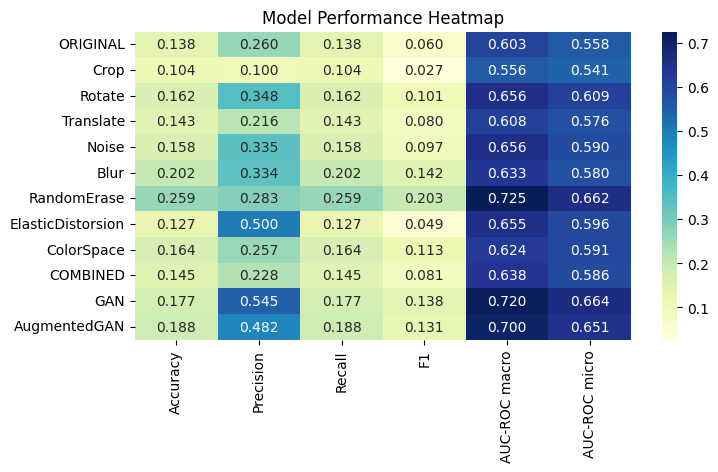

In [48]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df_results,
    annot=True, 
    cmap="YlGnBu",
    fmt='.3f'
)

plt.title("Model Performance Heatmap")
plt.show()